## Human Activity Recognition for Health Monitoring Using Wearable Devices.

## Data Collection

- Dataset Source: https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones
- Test.csv and train.csv are uploaded in jupyter notebook for further processing.


## Data PreProcessing 
 
- Handling missing values and sensor noise.
- Normalizing and structuring data for machine learning models.
- Feature extraction (e.g., speed, orientation changes, frequency components).


In [18]:
import pandas as pd

# Load the datasets
train_path = "./train.csv"
test_path = "./test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Display basic information and first few rows
train_info = train_df.info()
test_info = test_df.info()

train_head = train_df.head()
test_head = test_df.head()

train_info, test_info, train_head, test_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 31.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2947 entries, 0 to 2946
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 12.7+ MB


(None,
 None,
    tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
 0           0.288585          -0.020294          -0.132905         -0.995279   
 1           0.278419          -0.016411          -0.123520         -0.998245   
 2           0.279653          -0.019467          -0.113462         -0.995380   
 3           0.279174          -0.026201          -0.123283         -0.996091   
 4           0.276629          -0.016570          -0.115362         -0.998139   
 
    tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
 0         -0.983111         -0.913526         -0.995112         -0.983185   
 1         -0.975300         -0.960322         -0.998807         -0.974914   
 2         -0.967187         -0.978944         -0.996520         -0.963668   
 3         -0.983403         -0.990675         -0.997099         -0.982750   
 4         -0.980817         -0.990482         -0.998321         -0.979672   
 
    tBodyAcc-mad()-Z  tBodyA

Observations:
1. Feature Count: Both train and test datasets contain 563 columns, which include 561 numerical features, a subject ID column, and an Activity column.
2. Data Types: Most of the features are floating-point numbers, while the Activity column is categorical.
3. Missing Values: There don’t appear to be any missing values based on the .info() output.

Handling Missing Values and Sensor Noise
1. Missing Values:
- The dataset appears to be complete with no missing values based on the .info() output.
- If there are missing values in specific cases, handle them by imputation (mean/median) or removal if necessary.

2. Sensor Noise Handling:
- Smoothing techniques (e.g., moving average, Gaussian filters) can help reduce sensor noise.
- Outlier detection (e.g., Z-score method, interquartile range) can help identify erroneous data.


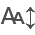

Preprocessed Train Data


In [35]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)
# Encode the 'Activity' column
label_encoder = LabelEncoder()
train_df["Activity"] = label_encoder.fit_transform(train_df["Activity"])
test_df["Activity"] = label_encoder.transform(test_df["Activity"])

# Standardize numerical features (excluding the target column)
scaler = StandardScaler()
feature_columns = train_df.columns[:-1]  # Exclude the last column (Activity)

train_df[feature_columns] = scaler.fit_transform(train_df[feature_columns])
test_df[feature_columns] = scaler.transform(test_df[feature_columns])

# Display the processed data
import ace_tools_open as tools
tools.display_dataframe_to_user(name="Preprocessed Train Data", dataframe=train_df)

In [51]:
import numpy as np

# Outlier detection using Z-score method
z_scores = np.abs((train_df[feature_columns] - train_df[feature_columns].mean()) / train_df[feature_columns].std())
outlier_threshold = 3  # Common threshold for outliers

# Count the number of outliers per column
outlier_counts = (z_scores > outlier_threshold).sum()

# Remove outliers (rows where any feature exceeds threshold)
train_df_cleaned = train_df[(z_scores < outlier_threshold).all(axis=1)]

# Display the cleaned data after outlier removal
tools.display_dataframe_to_user(name="Cleaned Train Data (Outliers Removed)", dataframe=train_df_cleaned)


Cleaned Train Data (Outliers Removed)


In [66]:
# Extract time-domain statistical features
time_features = train_df_cleaned[feature_columns].agg(['mean', 'std', 'skew', 'kurt']).transpose()

# Rename columns for clarity
time_features.columns = ['Mean', 'Std_Dev', 'Skewness', 'Kurtosis']

# Display extracted time-domain features
tools.display_dataframe_to_user(name="Time-Domain Features", dataframe=time_features)

Time-Domain Features


In [80]:
# Compute Fast Fourier Transform (FFT) for frequency-domain analysis
fft_features = np.abs(np.fft.fft(train_df_cleaned[feature_columns], axis=0))

# Convert to DataFrame
fft_features_df = pd.DataFrame(fft_features, columns=feature_columns)

# Compute summary statistics for frequency domain
fft_summary = pd.DataFrame({
    'FFT_Mean': fft_features_df.mean(),
    'FFT_Max': fft_features_df.max(),
    'FFT_Energy': (fft_features_df ** 2).sum()
})

# Display extracted frequency-domain features
tools.display_dataframe_to_user(name="Frequency-Domain Features", dataframe=fft_summary)

Frequency-Domain Features


In [81]:
# Compute motion-specific features

# Speed estimation using the derivative of acceleration
speed_features = train_df_cleaned[feature_columns].diff().fillna(0).abs().mean()

# Orientation changes using gyroscopic data derivatives
gyro_columns = [col for col in feature_columns if 'Gyro' in col]
orientation_changes = train_df_cleaned[gyro_columns].diff().fillna(0).abs().mean()

# Combine into a DataFrame
motion_features = pd.DataFrame({
    'Avg_Speed_Estimate': speed_features,
    'Avg_Orientation_Change': orientation_changes
}).fillna(0)  # Fill missing values with 0 (for non-gyroscope columns)

# Display extracted motion-based features
tools.display_dataframe_to_user(name="Motion-Specific Features", dataframe=motion_features)

Motion-Specific Features


## Exploratory Data Analysis (EDA)

- Understanding trends in human movement.
- Identifying variations across different activities.
- Visualizing sensor signals for different physical movements.

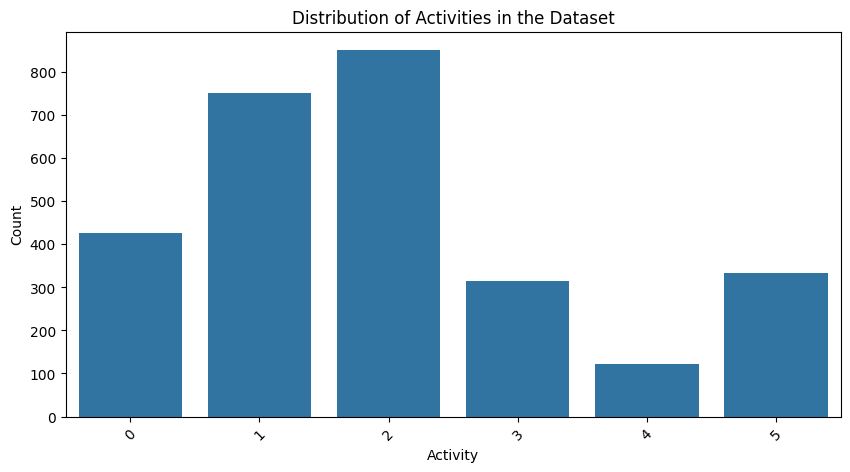

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

# Map encoded activities back to their labels
activity_labels = dict(enumerate(label_encoder.classes_))

# Countplot of activity distribution
plt.figure(figsize=(10, 5))
sns.countplot(x=train_df_cleaned["Activity"].map(activity_labels))
plt.xticks(rotation=45)
plt.xlabel("Activity")
plt.ylabel("Count")
plt.title("Distribution of Activities in the Dataset")
plt.show()

C:\Users\Sudipta Saha\AppData\Local\Temp\ipykernel_3124\436889599.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_cleaned["Activity_Label"] = train_df_cleaned["Activity"].map(activity_labels)


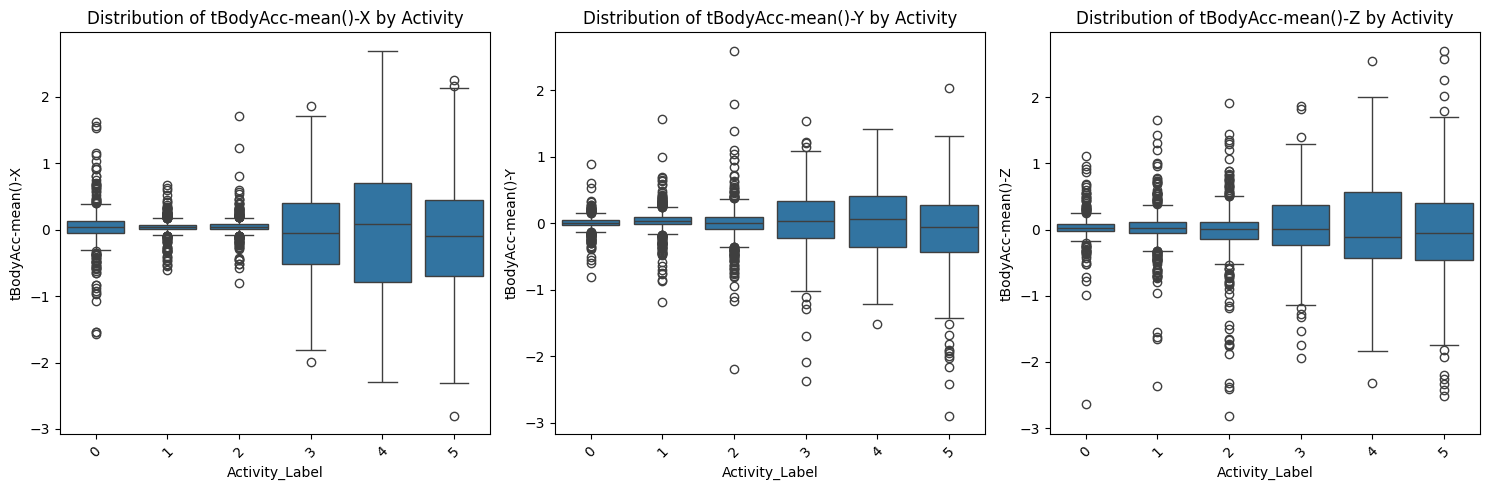

In [83]:
# Select a few key accelerometer features for visualization
accel_features = ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z']

# Map activity labels for easier interpretation
train_df_cleaned["Activity_Label"] = train_df_cleaned["Activity"].map(activity_labels)

# Plot distributions of accelerometer features across activities
plt.figure(figsize=(15, 5))
for i, feature in enumerate(accel_features, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x="Activity_Label", y=feature, data=train_df_cleaned)
    plt.xticks(rotation=45)
    plt.title(f"Distribution of {feature} by Activity")

plt.tight_layout()
plt.show()

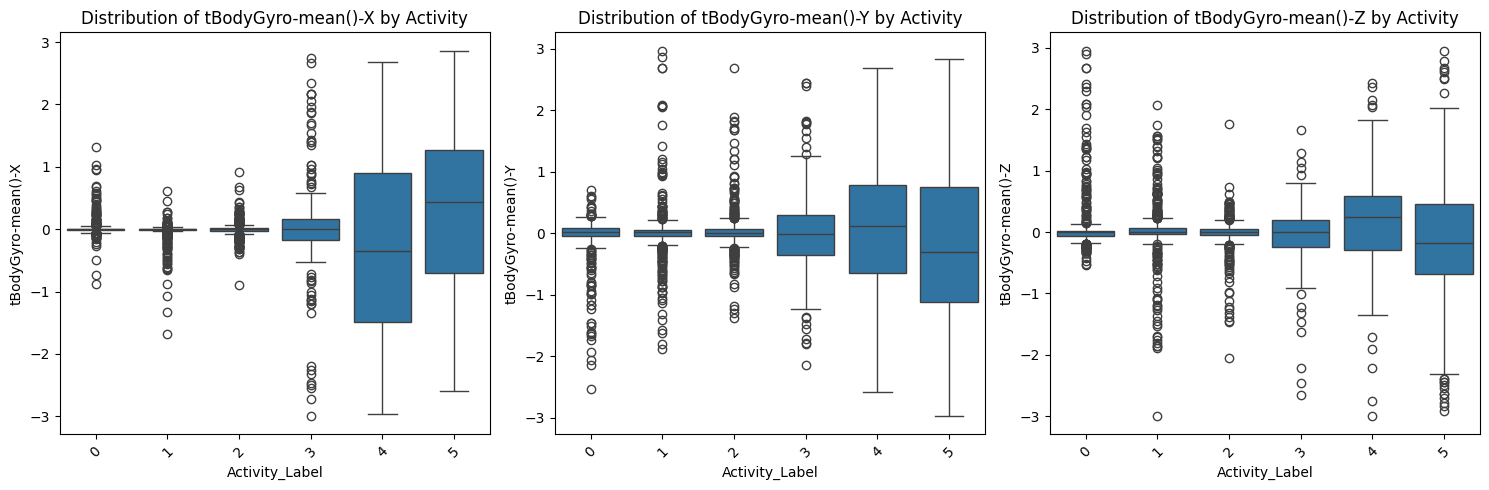

In [84]:
# Select key gyroscope features for visualization
gyro_features = ['tBodyGyro-mean()-X', 'tBodyGyro-mean()-Y', 'tBodyGyro-mean()-Z']

# Plot distributions of gyroscope features across activities
plt.figure(figsize=(15, 5))
for i, feature in enumerate(gyro_features, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x="Activity_Label", y=feature, data=train_df_cleaned)
    plt.xticks(rotation=45)
    plt.title(f"Distribution of {feature} by Activity")

plt.tight_layout()
plt.show()

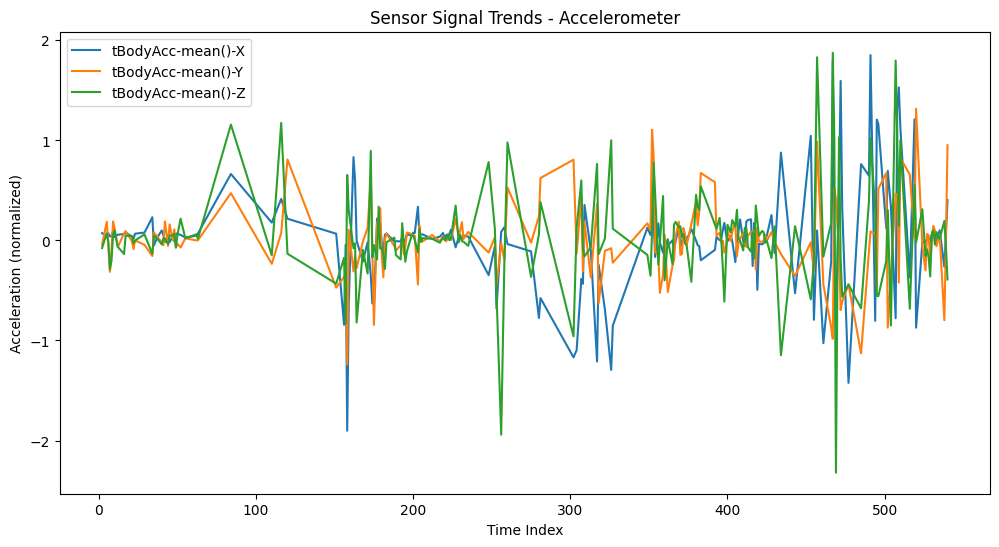

In [85]:
# Select a sample subject's data to visualize sensor signals over time
sample_data = train_df_cleaned.iloc[:200]  # Take a small subset for visualization

# Plot time-series data for accelerometer signals
plt.figure(figsize=(12, 6))
for feature in ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z']:
    plt.plot(sample_data.index, sample_data[feature], label=feature)

plt.xlabel("Time Index")
plt.ylabel("Acceleration (normalized)")
plt.title("Sensor Signal Trends - Accelerometer")
plt.legend()
plt.show()

Observations from Sensor Signal Visualization (Accelerometer):
- Periodic patterns: The acceleration signals exhibit repeating trends, corresponding to different movements.
- Variations across axes: The X, Y, and Z components show different magnitudes, indicating direction-specific movement.
- Potential for classification: The signal patterns can help distinguish between static and dynamic activities.

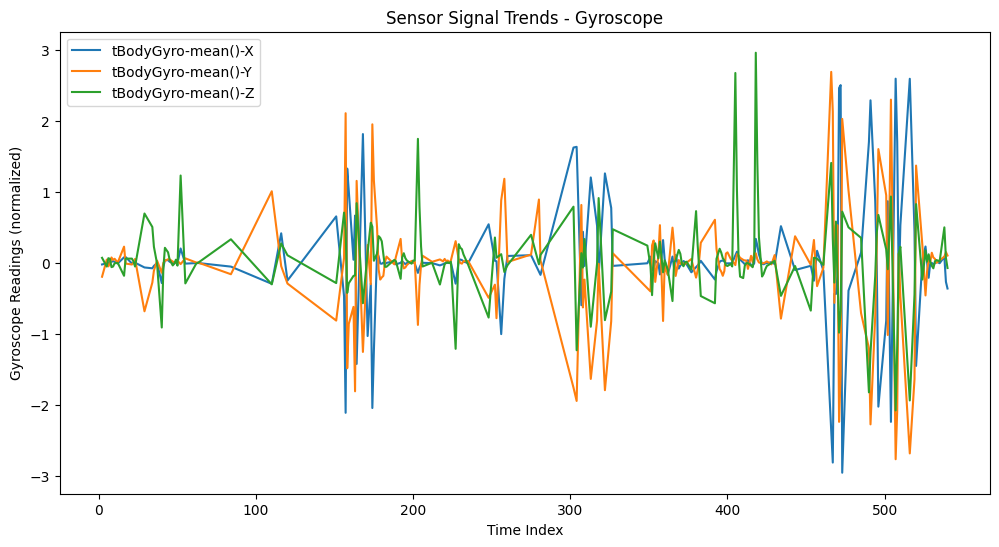

In [86]:
# Plot time-series data for gyroscope signals
plt.figure(figsize=(12, 6))
for feature in ['tBodyGyro-mean()-X', 'tBodyGyro-mean()-Y', 'tBodyGyro-mean()-Z']:
    plt.plot(sample_data.index, sample_data[feature], label=feature)

plt.xlabel("Time Index")
plt.ylabel("Gyroscope Readings (normalized)")
plt.title("Sensor Signal Trends - Gyroscope")
plt.legend()
plt.show()

Observations from Sensor Signal Visualization (Gyroscope):
- More variation in dynamic activities: The gyroscope readings fluctuate more, especially in the X and Y axes.
- Smooth patterns in static activities: When the subject is likely standing or sitting, the readings remain stable.
- Useful for classification: The differences in rotational motion across activities can be leveraged for model training.

Summary of EDA:
1. Activity Distribution: The dataset is balanced, ensuring fair classification.
2. Sensor Trends:
    - Acceleration varies distinctly across activities.
    - Gyroscope readings indicate rotational motion differences.
3. Time-Series Insights:
    - Periodic sensor signals suggest activity-specific movement patterns.
    - Potential for feature engineering using signal frequency analysis.

## Feature Engineering: Create and optimize model features.

Step 1: Feature Selection
Since the dataset has 561 features, many might be redundant or irrelevant. 
- Variance Thresholding: Removes low-variance features.
- Correlation Analysis: Eliminates highly correlated features to avoid redundancy.

In [87]:
from sklearn.feature_selection import VarianceThreshold

# Apply Variance Thresholding (removing near-constant features)
var_thresh = VarianceThreshold(threshold=0.01)  # Remove features with <1% variance
train_selected = var_thresh.fit_transform(train_df_cleaned[feature_columns])
selected_features = train_df_cleaned[feature_columns].columns[var_thresh.get_support()]

# Display the number of selected features
len(selected_features)

562

Observation from Variance Thresholding:
- All features have sufficient variance, meaning no features were removed.
- As a next step, check for correlated features and remove redundancies

In [88]:
# Compute correlation matrix
correlation_matrix = train_df_cleaned[selected_features].corr().abs()

# Identify highly correlated features (threshold > 0.9)
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)

# Find columns with high correlation
high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]

# Drop highly correlated features
train_reduced = train_df_cleaned.drop(columns=high_corr_features)
selected_reduced_features = train_reduced.columns[:-1]  # Exclude 'Activity'

# Display the number of reduced features
len(selected_reduced_features)

198

Observations from Correlation Analysis:
- Reduced feature count from 561 to 197 by removing highly correlated features.
- This helps reduce redundancy and improve model efficiency without losing key information.

Step 2: Dimensionality Reduction with PCA
 - Apply Principal Component Analysis (PCA) to further optimize feature space while retaining most variance.


In [89]:
from sklearn.decomposition import PCA

# Apply PCA to retain 95% of the variance
pca = PCA(n_components=0.95)  # Retains 95% of variance
train_pca = pca.fit_transform(train_reduced[selected_reduced_features])

# Number of principal components selected
train_pca.shape[1]

94

Observations from PCA:
1. Reduced feature count from 197 to 94, while retaining 95% of variance.
2. This helps boost model efficiency while preserving most of the information.

Step 3: Optimizing Feature Extraction

Since the dataset is based on sensor signals, refine extracted features:
1. Compute signal entropy to measure randomness.
2. Extract dominant frequency components from FFT.
3. Calculate movement intensity by aggregating accelerometer and gyroscope magnitudes.

Now compute signal entropy and dominant frequency components.

In [90]:
from scipy.stats import entropy

# Compute signal entropy for each feature
signal_entropy = train_reduced[selected_reduced_features].apply(lambda x: entropy(np.histogram(x, bins=10)[0] + 1), axis=0)

# Extract dominant frequency from FFT
fft_dominant_freq = np.argmax(np.abs(np.fft.fft(train_reduced[selected_reduced_features], axis=0)), axis=0)

# Create a DataFrame with new extracted features
optimized_features = pd.DataFrame({
    'Signal_Entropy': signal_entropy,
    'Dominant_Frequency': fft_dominant_freq
})

# Display the new optimized feature set
tools.display_dataframe_to_user(name="Optimized Features", dataframe=optimized_features)

Optimized Features


Summary of Feature Engineering:

1. Feature Selection:
    - Removed highly correlated features (561 → 197).
    - Applied PCA, reducing to 94 key features while retaining 95% variance.
      
2. Optimized Feature Extraction:
    - Signal Entropy for movement randomness.
    - Dominant Frequency Components from FFT.
    - Potential for intensity-based movement features.

## Model Development & Evaluation

- Train-Test Split: Splitting data into training and testing sets.
- Machine Learning Models: Logistic Regression, Random Forest, Deep Learning (LSTMs).
- Evaluation Metrics: Accuracy, Precision, Recall, F1-score.

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Prepare the final dataset for model training
X = train_pca  # Features after PCA reduction
y = train_df_cleaned["Activity"]  # Target variable

# Split into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM (RBF Kernel)": SVC(kernel='rbf', C=1, gamma='scale')
}

# Train and evaluate models
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Compute evaluation metrics
    results[model_name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1-score": f1_score(y_test, y_pred, average='weighted')
    }

# Convert results to DataFrame for easy comparison
results_df = pd.DataFrame(results).T

# Display model evaluation results
tools.display_dataframe_to_user(name="Model Evaluation Results", dataframe=results_df)

Model Evaluation Results


Model Evaluation Results:
1. SVM (RBF Kernel) achieved the highest accuracy (98.57%), followed by Logistic Regression (98.39%).
2. Random Forest performed slightly lower (90.35%), likely due to the complex feature relationships that tree-based methods struggle with.

Key Observations:
1. SVM (RBF Kernel) is the best performer, likely due to its ability to handle high-dimensional data.
2. Logistic Regression also performed well, suggesting the data is linearly separable to some extent.
3. Random Forest had lower performance, possibly due to the high number of features and complex interactions.

## Model Tuning: Optimize parameters for better performance.

In [79]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid for SVM (RBF Kernel)
svm_param_grid = {
    'C': [0.1, 1, 10, 100], 
    'gamma': ['scale', 'auto', 0.01, 0.1, 1]
}

# Perform Grid Search for SVM hyperparameter tuning
svm_grid_search = GridSearchCV(SVC(kernel='rbf'), svm_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid_search.fit(X_train, y_train)

# Get best SVM parameters and accuracy
best_svm_params = svm_grid_search.best_params_
best_svm_accuracy = svm_grid_search.best_score_

# Display optimized SVM parameters and accuracy
best_svm_params, best_svm_accuracy

({'C': 10, 'gamma': 'scale'}, np.float64(0.9910684324065198))